### Carotid Project - radiomicsOnly

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from skrebate import ReliefF
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [9]:
# Read the CSV file
file_path = "imagingOnly.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    
    # Show the columns
    print("Columns in the dataset:")
    print(df.columns)
    
    # Find null values inside each column
    print("\nNull values in each column:")
    null_counts = df.isnull().sum()
    print(null_counts)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except pd.errors.EmptyDataError:
    print(f"File '{file_path}' is empty.")
except pd.errors.ParserError as e:
    print(f"Error parsing the CSV file: {e}")

Dataset loaded successfully.
Columns in the dataset:
Index(['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor',
       'Rt CCA Distal far wall mean IMT (mm)',
       'Lt CCA Distal far wall mean IMT (mm)',
       'Mean CIMT, CCA far distal (mm)', 'Rt Max Plaque Height (mm)',
       'Lt Max Plaque Height (mm)',
       'Max Plaque Height (PH), Rt or Lt Bulbs (mm)', 'Max PH ≥1.5 mm',
       'Rt Area (mm2)', 'Lt Area (mm2)',
       'Total Plaque Area (TPA), Rt + Lt Bulbs (mm2)',
       'Right GSM (all sections)', 'RT % blood (0-4)', 'RT % fat (8-26)',
       'RT % muscle (41-76)', 'RT % fibrous tissue (112-196)',
       'RT % calcium (211-255)', 'RT % undefined', 'RT % p40',
       'Left GSM (all sections)', 'LT % blood (0-4)', 'LT % fat (8-26)',
       'LT % muscle (41-76)', 'LT % fibrous tissue (112-196)',
       'LT % calcium (211-255)', 'LT % undefined', 'LT p40',
       'Mean GSM (Rt & Lt)', 'adjusted mean % blood (0-4)',
       'adjusted fat (8-26)', 'adjusted mean % muscle (41-76)',
   

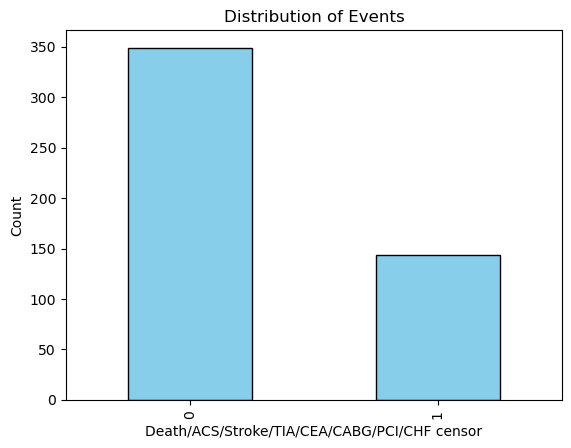

In [10]:
# Assuming the first column is the predictor column (you may need to adjust the column name accordingly)
predictor_column = df.columns[0]

# Visualize the ratio of events in the predictor column
event_counts = df[predictor_column].value_counts()
event_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel(predictor_column)
plt.ylabel('Count')
plt.title('Distribution of Events')
plt.show()

### Preprocessing and Feature Selection

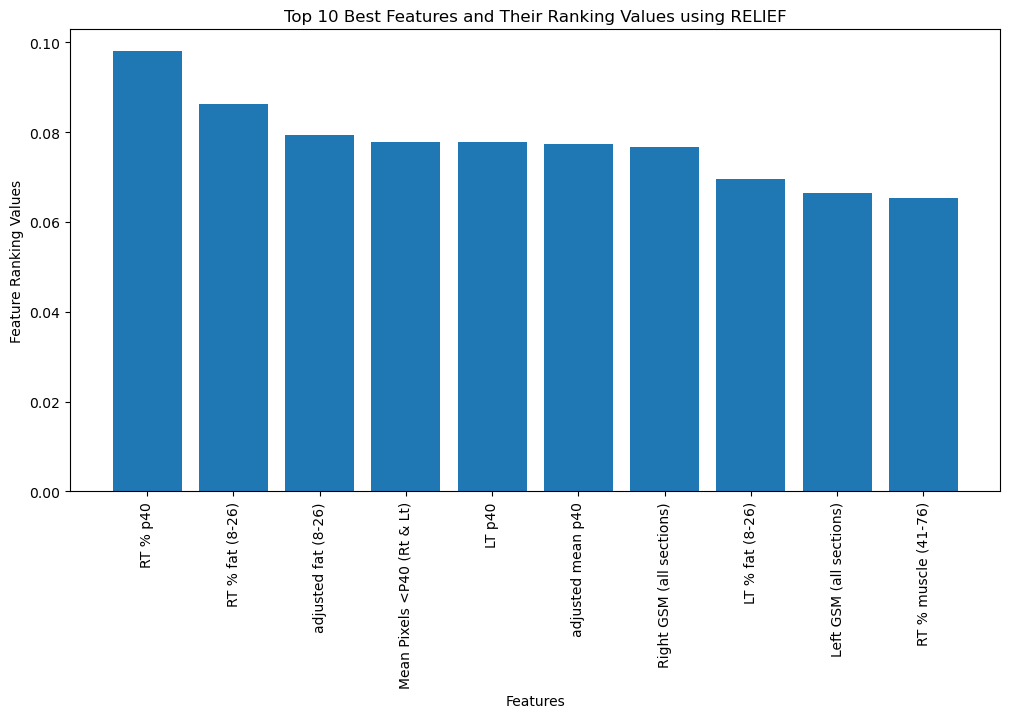

Top 10 Best Features:
RT % p40: 0.0980
RT % fat (8-26): 0.0863
adjusted fat (8-26): 0.0795
Mean Pixels <P40 (Rt & Lt): 0.0778
LT p40: 0.0777
adjusted mean p40: 0.0775
Right GSM (all sections): 0.0767
LT % fat (8-26): 0.0696
Left GSM (all sections): 0.0664
RT % muscle (41-76): 0.0653


In [11]:
# Data preprocessing: clean the dataset and normalize numerical features
# Assuming all columns except the predictor column are numerical features
numerical_features = df.columns[1:]

# Clean the dataset by removing rows with missing values
df.dropna(inplace=True)

# Normalize the numerical features using StandardScaler
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Feature selection using RELIEF algorithm
X = df.drop(predictor_column, axis=1)
y = df[predictor_column]

# Instantiate the ReliefF class and fit the data
relief = ReliefF(n_features_to_select=10, n_neighbors=100)
relief.fit(X.values, y.values)

# Get the feature ranking values
feature_ranking_values = relief.feature_importances_

# Get the top 10 best features
selected_feature_indices = relief.top_features_[:10]  # Select only the top 10 features
selected_features = X.columns[selected_feature_indices]

# Visualize the top 10 best features and their ranking values
plt.figure(figsize=(12, 6))
plt.bar(range(len(selected_features)), feature_ranking_values[selected_feature_indices], tick_label=selected_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Ranking Values')
plt.title('Top 10 Best Features and Their Ranking Values using RELIEF')
plt.show()

# Print out the names of the top 10 best features along with their ranking values
print("Top 10 Best Features:")
for feature, ranking in zip(selected_features, feature_ranking_values[selected_feature_indices]):
    print(f"{feature}: {ranking:.4f}")

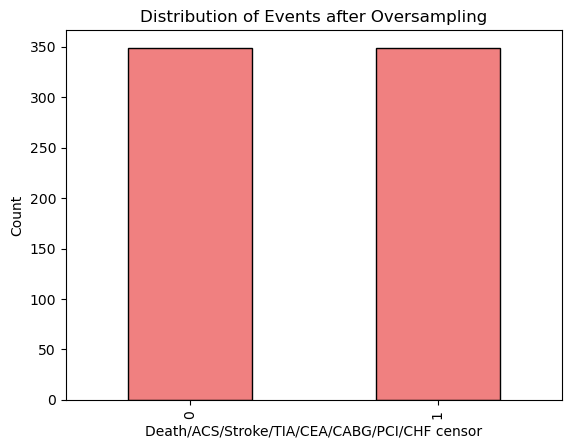

In [12]:
# Oversampling
# Instantiate the RandomOverSampler class
random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Perform oversampling on the dataset
X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

# Create a new DataFrame with the oversampled data
oversampled_df = pd.concat([pd.DataFrame(X_resampled, columns=selected_features), pd.DataFrame(y_resampled, columns=[predictor_column])], axis=1)


# Visualize the ratio of events in the predictor column after oversampling
event_counts_oversampled = oversampled_df[predictor_column].value_counts()
event_counts_oversampled.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel(predictor_column)
plt.ylabel('Count')
plt.title('Distribution of Events after Oversampling')
plt.show()


### Machine Learning 

In [13]:
# # Convert X_resampled and y_resampled to DataFrames
# X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
# y_resampled_df = pd.Series(y_resampled, name=predictor_column)

# # Define a list of C values to test
# c_values = [0.1, 1, 10]

# # Define a list of K folds to use
# k_folds = [3, 5, 10]

# # Create a dictionary to store AUC scores for each combination of C value and K fold
# auc_scores = {}

# # Plot the ROC curve for each combination of C value and K fold
# plt.figure(figsize=(10, 8))

# for c_value in c_values:
#     for k in k_folds:
#         svm_classifier = SVC(C=c_value, probability=True)
#         cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
#         mean_fpr = np.linspace(0, 1, 100)
#         tpr_sum = 0
        
#         for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
#             X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
#             y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]

#             svm_classifier.fit(X_train, y_train)
#             y_prob = svm_classifier.predict_proba(X_test)[:, 1]
#             fpr, tpr, _ = roc_curve(y_test, y_prob)

#             # Interpolate the TPR values to get the same points for each fold
#             tpr_sum += np.interp(mean_fpr, fpr, tpr)

#         mean_tpr = tpr_sum / k
#         auc_val = auc(mean_fpr, mean_tpr)
#         auc_scores[(c_value, k)] = auc_val

#         plt.plot(mean_fpr, mean_tpr, label=f"C = {c_value}, K-Fold = {k}, AUC = {auc_val:.4f}")

# # Plot the diagonal line representing random guessing
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for SVM with Different C Values and K Folds')
# plt.legend(loc='lower right')
# plt.show()

# # Find the combination of C value and K fold with the highest AUC score
# best_combination = max(auc_scores, key=auc_scores.get)
# best_c_value, best_k_fold = best_combination

# # Plot the ROC curve for the best combination
# plt.figure(figsize=(10, 8))
# svm_classifier = SVC(C=best_c_value, probability=True)
# cv = StratifiedKFold(n_splits=best_k_fold, shuffle=True, random_state=42)

# mean_fpr = np.linspace(0, 1, 100)
# tpr_sum = 0

# for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
#     X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
#     y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]

#     svm_classifier.fit(X_train, y_train)
#     y_prob = svm_classifier.predict_proba(X_test)[:, 1]
#     fpr, tpr, _ = roc_curve(y_test, y_prob)

#     # Interpolate the TPR values to get the same points for each fold
#     tpr_sum += np.interp(mean_fpr, fpr, tpr)

# mean_tpr = tpr_sum / best_k_fold
# best_auc_val = auc(mean_fpr, mean_tpr)

# plt.plot(mean_fpr, mean_tpr, label=f"Best C = {best_c_value}, Best K-Fold = {best_k_fold}, AUC = {best_auc_val:.4f}")

# # Plot the diagonal line representing random guessing
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for SVM with Best C Value and K Fold')
# plt.legend(loc='lower right')
# plt.show()

# # Print the best combination of C value and K fold
# print(f"Best Combination: C = {best_c_value}, K-Fold = {best_k_fold}, Best AUC = {best_auc_val:.4f}")

# # Print the AUC scores for each combination of C value and K fold
# print("AUC Scores:")
# for (c_value, k), auc_val in auc_scores.items():
#     print(f"C = {c_value}, K-Fold = {k}: AUC = {auc_val:.4f}")

In [14]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
# from xgboost import XGBClassifier

# # Clean column names
# X_resampled_df.columns = X_resampled_df.columns.str.replace('[', '')
# X_resampled_df.columns = X_resampled_df.columns.str.replace(']', '')
# X_resampled_df.columns = X_resampled_df.columns.str.replace('<', '')

# # Define the classifiers
# classifiers = {
#     'SVM': SVC(probability=True),
#     'KNN': KNeighborsClassifier(),
#     'RandomForest': RandomForestClassifier(),
#     'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# }

# # Define the hyperparameters for each classifier
# hyperparameters = {
#     'SVM': {'C': [0.1, 1, 10]},
#     'KNN': {'n_neighbors': [3, 5, 7]},
#     'RandomForest': {'n_estimators': [100, 200, 300]},
#     'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1]}
# }

# k_folds = [3, 5, 10]
# results = {}

# for name, classifier in classifiers.items():
#     best_auc = 0
#     best_params = None
#     best_k = None
#     best_precision = None
#     best_recall = None
#     best_f1_score = None
#     best_accuracy = None
#     for k in k_folds:
#         cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
#         mean_fpr = np.linspace(0, 1, 100)
#         for param_name, param_values in hyperparameters[name].items():
#             for param_value in param_values:
#                 clf = classifier.set_params(**{param_name: param_value})
#                 tpr_sum = 0
#                 precision_scores = []
#                 recall_scores = []
#                 f1_scores = []
#                 accuracy_scores = []
#                 for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
#                     X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
#                     y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]
#                     clf.fit(X_train, y_train)
#                     y_pred = clf.predict(X_test)
#                     y_prob = clf.predict_proba(X_test)[:, 1]
#                     precision_scores.append(precision_score(y_test, y_pred))
#                     recall_scores.append(recall_score(y_test, y_pred))
#                     f1_scores.append(f1_score(y_test, y_pred))
#                     accuracy_scores.append(accuracy_score(y_test, y_pred))
#                     fpr, tpr, _ = roc_curve(y_test, y_prob)
#                     tpr_sum += np.interp(mean_fpr, fpr, tpr)
#                 mean_tpr = tpr_sum / k
#                 auc_val = auc(mean_fpr, mean_tpr)
#                 if auc_val > best_auc:
#                     best_auc = auc_val
#                     best_params = f"{param_name}={param_value}"
#                     best_k = k
#                     best_precision = np.mean(precision_scores)
#                     best_recall = np.mean(recall_scores)
#                     best_f1_score = np.mean(f1_scores)
#                     best_accuracy = np.mean(accuracy_scores)
#     results[name] = {'Params': best_params, 'K-Fold': best_k, 'AUC': best_auc,
#                      'Precision': best_precision, 'Recall': best_recall, 'F1-Score': best_f1_score, 'Accuracy': best_accuracy}
#     plt.plot(mean_fpr, mean_tpr, label=f"{name}, Params = {best_params}, K-Fold = {best_k}, AUC = {best_auc:.4f}")

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Best Model of Each Classifier')

# # Move the legend outside of the graph using bbox_to_anchor
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Save the figure as PNG without compression
# plt.savefig('imagingOnly.png', dpi=300, bbox_inches='tight')

# # Show the plot (optional)
# plt.show()

# # Print the sorted AUC scores
# results_sorted = sorted(results.items(), key=lambda item: item[1]['AUC'], reverse=True)
# for clf_name, metrics in results_sorted:
#     print(f"Best {clf_name} Model, Params: {metrics['Params']}, K-Fold: {metrics['K-Fold']}, AUC: {metrics['AUC']:.4f}, Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, F1-Score: {metrics['F1-Score']:.4f}, Accuracy: {metrics['Accuracy']:.4f}")

C:\Users\mojta\AppData\Local\Temp\ipykernel_23328\3032340982.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_resampled_df.columns = X_resampled_df.columns.str.replace('[', '')
C:\Users\mojta\AppData\Local\Temp\ipykernel_23328\3032340982.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_resampled_df.columns = X_resampled_df.columns.str.replace(']', '')
C:\Users\mojta\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


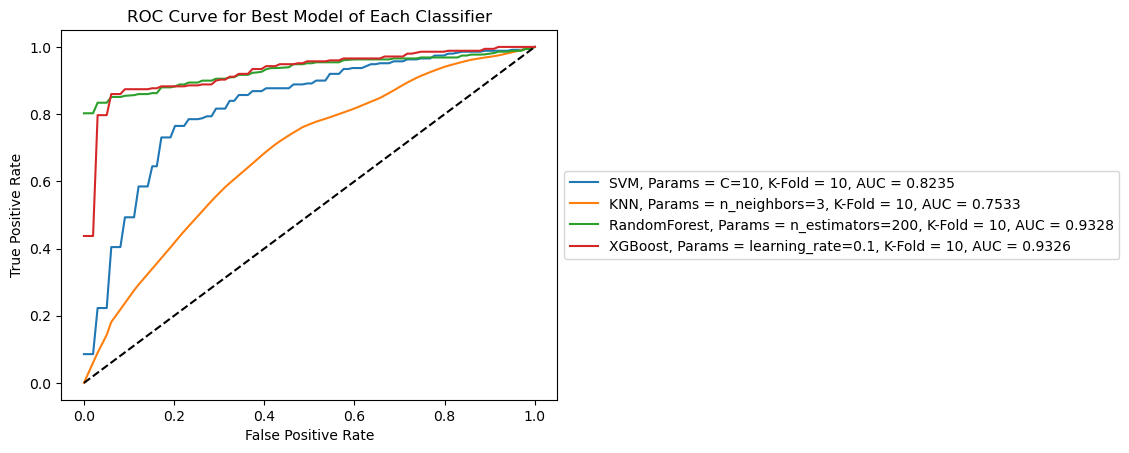

Best RandomForest Model, Params: n_estimators=200, K-Fold: 10, AUC: 0.9328, Precision: 0.8180 ± 0.0438, Recall: 0.8825 ± 0.0349, F1-Score: 0.8476 ± 0.0194, Accuracy: 0.8411 ± 0.0230
Best XGBoost Model, Params: learning_rate=0.1, K-Fold: 10, AUC: 0.9326, Precision: 0.8068 ± 0.0505, Recall: 0.8884 ± 0.0500, F1-Score: 0.8438 ± 0.0298, Accuracy: 0.8354 ± 0.0322
Best SVM Model, Params: C=10, K-Fold: 10, AUC: 0.8235, Precision: 0.7347 ± 0.0528, Recall: 0.8307 ± 0.0561, F1-Score: 0.7786 ± 0.0454, Accuracy: 0.7636 ± 0.0501
Best KNN Model, Params: n_neighbors=3, K-Fold: 10, AUC: 0.7533, Precision: 0.6604 ± 0.0684, Recall: 0.8224 ± 0.0566, F1-Score: 0.7307 ± 0.0531, Accuracy: 0.6950 ± 0.0671


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier

X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name=predictor_column)

# Clean column names
X_resampled_df.columns = X_resampled_df.columns.str.replace('[', '')
X_resampled_df.columns = X_resampled_df.columns.str.replace(']', '')
X_resampled_df.columns = X_resampled_df.columns.str.replace('<', '')

# Define the classifiers
classifiers = {
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define the hyperparameters for each classifier
hyperparameters = {
    'SVM': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'RandomForest': {'n_estimators': [100, 200, 300]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1]}
}

k_folds = [3, 5, 10]
results = {}

for name, classifier in classifiers.items():
    best_auc = 0
    best_params = None
    best_k = None
    best_precision = None
    best_recall = None
    best_f1_score = None
    best_accuracy = None
    for k in k_folds:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        mean_fpr = np.linspace(0, 1, 100)
        for param_name, param_values in hyperparameters[name].items():
            for param_value in param_values:
                clf = classifier.set_params(**{param_name: param_value})
                tpr_sum = 0
                precision_scores = []
                recall_scores = []
                f1_scores = []
                accuracy_scores = []
                for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
                    X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
                    y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    y_prob = clf.predict_proba(X_test)[:, 1]
                    precision_scores.append(precision_score(y_test, y_pred))
                    recall_scores.append(recall_score(y_test, y_pred))
                    f1_scores.append(f1_score(y_test, y_pred))
                    accuracy_scores.append(accuracy_score(y_test, y_pred))
                    fpr, tpr, _ = roc_curve(y_test, y_prob)
                    tpr_sum += np.interp(mean_fpr, fpr, tpr)
                mean_tpr = tpr_sum / k
                auc_val = auc(mean_fpr, mean_tpr)
                if auc_val > best_auc:
                    best_auc = auc_val
                    best_params = f"{param_name}={param_value}"
                    best_k = k
                    best_precision = (np.mean(precision_scores), np.std(precision_scores))
                    best_recall = (np.mean(recall_scores), np.std(recall_scores))
                    best_f1_score = (np.mean(f1_scores), np.std(f1_scores))
                    best_accuracy = (np.mean(accuracy_scores), np.std(accuracy_scores))

    results[name] = {'Params': best_params, 'K-Fold': best_k, 'AUC': best_auc,
                     'Precision': best_precision, 'Recall': best_recall, 'F1-Score': best_f1_score, 'Accuracy': best_accuracy}
    
    plt.plot(mean_fpr, mean_tpr, label=f"{name}, Params = {best_params}, K-Fold = {best_k}, AUC = {best_auc:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model of Each Classifier')

# Move the legend outside of the graph using bbox_to_anchor
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the figure as PNG without compression
plt.savefig('allData.png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

# Print the sorted AUC scores
results_sorted = sorted(results.items(), key=lambda item: item[1]['AUC'], reverse=True)
for clf_name, metrics in results_sorted:
    print(f"Best {clf_name} Model, Params: {metrics['Params']}, K-Fold: {metrics['K-Fold']}, AUC: {metrics['AUC']:.4f}, Precision: {metrics['Precision'][0]:.4f} ± {metrics['Precision'][1]:.4f}, Recall: {metrics['Recall'][0]:.4f} ± {metrics['Recall'][1]:.4f}, F1-Score: {metrics['F1-Score'][0]:.4f} ± {metrics['F1-Score'][1]:.4f}, Accuracy: {metrics['Accuracy'][0]:.4f} ± {metrics['Accuracy'][1]:.4f}")

In [1]:
import pandas as pd

# Define the data
data = {
    'Feature Type': ['imagingOnly', 'imagingOnly', 'imagingOnly', 'imagingOnly',
                     'radiomicsOnly', 'radiomicsOnly', 'radiomicsOnly', 'radiomicsOnly',
                     'clinHistOnly', 'clinHistOnly', 'clinHistOnly', 'clinHistOnly',
                     'clinHistAndImaging', 'clinHistAndImaging', 'clinHistAndImaging', 'clinHistAndImaging',
                     'radiomicsAndClinHist', 'radiomicsAndClinHist', 'radiomicsAndClinHist', 'radiomicsAndClinHist',
                     'radiomicsAndImaging', 'radiomicsAndImaging', 'radiomicsAndImaging', 'radiomicsAndImaging',
                     'allData', 'allData', 'allData', 'allData'],
    'Model': ['RandomForest', 'XGBoost', 'SVM', 'KNN',
              'RandomForest', 'XGBoost', 'SVM', 'KNN',
              'RandomForest', 'XGBoost', 'SVM', 'KNN',
              'RandomForest', 'XGBoost', 'SVM', 'KNN',
              'XGBoost', 'RandomForest', 'SVM', 'KNN',
              'XGBoost', 'RandomForest', 'SVM', 'KNN',
              'XGBoost', 'SVM', 'RandomForest', 'KNN'],
    'Params': ['n_estimators=200', 'learning_rate=0.1', 'C=10', 'n_neighbors=3',
               'n_estimators=200', 'learning_rate=0.1', 'C=10', 'n_neighbors=3',
               'n_estimators=300', 'n_estimators=300', 'C=10', 'n_neighbors=3',
               'n_estimators=300', 'learning_rate=0.1', 'C=10', 'n_neighbors=3',
               'learning_rate=0.1', 'n_estimators=300', 'C=10', 'n_neighbors=3',
               'learning_rate=0.1', 'n_estimators=300', 'C=10', 'n_neighbors=7',
               'learning_rate=0.1', 'C=10', 'n_estimators=300', 'n_neighbors=3'],
    'K-Fold': [10, 10, 10, 10,
               10, 10, 10, 10,
               10, 5, 10, 10,
               10, 10, 10, 10,
               10, 10, 10, 5,
               10, 10, 10, 10,
               10, 10, 10, 10],
    'AUC': [0.9328, 0.9326, 0.8235, 0.7533,
            0.8064, 0.7849, 0.7184, 0.7042,
            0.9273, 0.8989, 0.8264, 0.7805,
            0.9330, 0.9268, 0.8933, 0.7379,
            0.9004, 0.8540, 0.8382, 0.7524,
            0.9836, 0.8955, 0.8182, 0.7090,
            0.9908, 0.9199, 0.9052, 0.7707],
    'Precision': ['0.8180 ± 0.0858', '0.8068 ± 0.0990', '0.7347 ± 0.1035', '0.6604 ± 0.1341',
                  '0.7213 ± 0.1262', '0.7027 ± 0.0664', '0.6641 ± 0.0839', '0.6587 ± 0.1045',
                  '0.8549 ± 0.1045', '0.7738 ± 0.0835', '0.7238 ± 0.0547', '0.6964 ± 0.1121',
                  '0.8393 ± 0.0982', '0.8004 ± 0.0749', '0.7679 ± 0.0876', '0.6644 ± 0.1100',
                  '0.8051 ± 0.1201', '0.7338 ± 0.1313', '0.7481 ± 0.1162', '0.6952 ± 0.0811',
                  '0.9290 ± 0.0958', '0.7949 ± 0.1203', '0.7370 ± 0.1094', '0.6229 ± 0.0735',
                  '0.9569 ± 0.0576', '0.8166 ± 0.1213', '0.8048 ± 0.1311', '0.6672 ± 0.1096'],
    'Recall': ['0.8825 ± 0.0684', '0.8884 ± 0.0980', '0.8307 ± 0.1100', '0.8224 ± 0.1109',
               '0.7229 ± 0.1294', '0.7119 ± 0.1339', '0.7230 ± 0.1337', '0.6870 ± 0.1245',
               '0.8740 ± 0.1035', '0.9027 ± 0.0406', '0.8310 ± 0.0806', '0.7792 ± 0.1131',
               '0.8768 ± 0.0831', '0.8855 ± 0.0749', '0.8738 ± 0.1078', '0.7735 ± 0.1168',
               '0.8098 ± 0.1731', '0.7866 ± 0.1899', '0.8099 ± 0.1190', '0.7340 ± 0.0314',
               '0.9441 ± 0.0872', '0.8187 ± 0.1219', '0.7895 ± 0.1111', '0.7634 ± 0.1923',
               '0.9589 ± 0.0643', '0.8889 ± 0.1086', '0.8334 ± 0.1358', '0.7629 ± 0.1725'],
    'F1-Score': ['0.8476 ± 0.0380', '0.8438 ± 0.0584', '0.7786 ± 0.0890', '0.7310 ± 0.0923',
                 '0.7219 ± 0.1278', '0.7068 ± 0.0894', '0.6923 ± 0.1075', '0.6723 ± 0.1142',
                 '0.8638 ± 0.0934', '0.8340 ± 0.0612', '0.7748 ± 0.0667', '0.7358 ± 0.1124',
                 '0.8571 ± 0.0909', '0.8409 ± 0.0749', '0.8184 ± 0.0967', '0.7159 ± 0.1130',
                 '0.8074 ± 0.1462', '0.7592 ± 0.1604', '0.7785 ± 0.1176', '0.7141 ± 0.0555',
                 '0.9365 ± 0.0911', '0.8063 ± 0.1209', '0.7627 ± 0.1102', '0.6865 ± 0.1324',
                 '0.9579 ± 0.0610', '0.8512 ± 0.1149', '0.8186 ± 0.1332', '0.7125 ± 0.1407'],
    'Accuracy': ['0.9125 ± 0.0384', '0.9086 ± 0.0588', '0.8427 ± 0.0896', '0.7980 ± 0.0927',
                 '0.7829 ± 0.1272', '0.7668 ± 0.0898', '0.7523 ± 0.1079', '0.7323 ± 0.1146',
                 '0.8938 ± 0.0938', '0.8640 ± 0.0616', '0.8048 ± 0.0663', '0.7658 ± 0.1128',
                 '0.8871 ± 0.0903', '0.8709 ± 0.0743', '0.8484 ± 0.0961', '0.7459 ± 0.1134',
                 '0.8374 ± 0.1466', '0.7892 ± 0.1608', '0.8085 ± 0.1170', '0.7441 ± 0.0559',
                 '0.9665 ± 0.0915', '0.8363 ± 0.1203', '0.7927 ± 0.1106', '0.7165 ± 0.1328',
                 '0.9879 ± 0.0614', '0.8812 ± 0.1143', '0.8486 ± 0.1336', '0.7425 ± 0.1403']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

# If you want to save the table to a CSV file
df.to_csv('results_table.csv', index=False)


            Feature Type         Model             Params  K-Fold     AUC  \
0            imagingOnly  RandomForest   n_estimators=200      10  0.9328   
1            imagingOnly       XGBoost  learning_rate=0.1      10  0.9326   
2            imagingOnly           SVM               C=10      10  0.8235   
3            imagingOnly           KNN      n_neighbors=3      10  0.7533   
4          radiomicsOnly  RandomForest   n_estimators=200      10  0.8064   
5          radiomicsOnly       XGBoost  learning_rate=0.1      10  0.7849   
6          radiomicsOnly           SVM               C=10      10  0.7184   
7          radiomicsOnly           KNN      n_neighbors=3      10  0.7042   
8           clinHistOnly  RandomForest   n_estimators=300      10  0.9273   
9           clinHistOnly       XGBoost   n_estimators=300       5  0.8989   
10          clinHistOnly           SVM               C=10      10  0.8264   
11          clinHistOnly           KNN      n_neighbors=3      10  0.7805   